In [9]:
from torch_snippets import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
device = 'cpu'
train_dataset = datasets.MNIST(root='MNIST/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='MNIST/', train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder network
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc21 = nn.Linear(256, 20)  # mu
        self.fc22 = nn.Linear(256, 20)  # logvar
        
        # Decoder network
        self.fc3 = nn.Linear(20, 256)
        self.fc4 = nn.Linear(256, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        mu = self.fc21(x)
        logvar = self.fc22(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = Variable(torch.randn(std.size())).cpu()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = z.view(z.size(0), 64, 7, 7)
        z = F.relu(self.deconv1(z))
        z = torch.sigmoid(self.deconv2(z))
        return z
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar

In [18]:
def train_batch(data, model, optimizer, loss_function):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()



@torch.no_grad()
def validate_batch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    recon, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon, data, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

In [19]:
def loss_function(recon_x, x, mean, log_var):
    RECON = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return RECON + KLD, RECON, KLD

EPOCH: 1.000  val_log_var: -0.826  train_mean: -0.002  val_mean: 0.016  train_recon: 2705.059  train_log_var: -0.361  train_kld: 252.136  train_loss: 2957.195  val_kld: 531.068  val_loss: 2058.609  val_recon: 1527.542  (19.19s - 172.71s remaining)


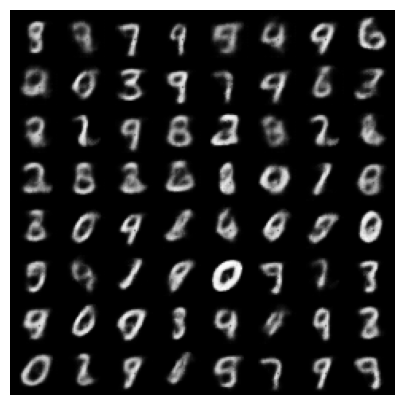

EPOCH: 2.000  val_log_var: -0.981  train_mean: 0.002  val_mean: 0.007  train_recon: 1520.753  train_log_var: -0.906  train_kld: 584.765  train_loss: 2105.518  val_kld: 625.286  val_loss: 1726.601  val_recon: 1101.316  (40.62s - 162.49s remaining)


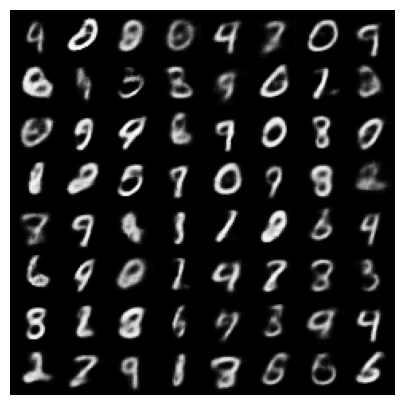

EPOCH: 3.000  val_log_var: -1.057  train_mean: 0.003  val_mean: 0.004  train_recon: 1321.151  train_log_var: -1.008  train_kld: 647.093  train_loss: 1968.245  val_kld: 669.109  val_loss: 1644.590  val_recon: 975.481  (62.59s - 146.04s remaining)


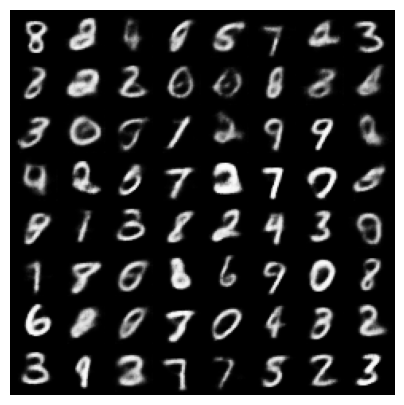

EPOCH: 4.000  val_log_var: -1.068  train_mean: 0.002  val_mean: 0.005  train_recon: 1239.808  train_log_var: -1.052  train_kld: 673.729  train_loss: 1913.537  val_kld: 683.823  val_loss: 1614.425  val_recon: 930.602  (84.61s - 126.91s remaining)


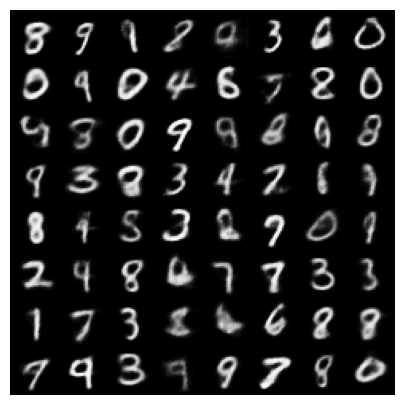

EPOCH: 5.000  val_log_var: -1.058  train_mean: 0.002  val_mean: 0.023  train_recon: 1195.640  train_log_var: -1.075  train_kld: 687.599  train_loss: 1883.239  val_kld: 670.764  val_loss: 1566.278  val_recon: 895.514  (106.23s - 106.23s remaining)


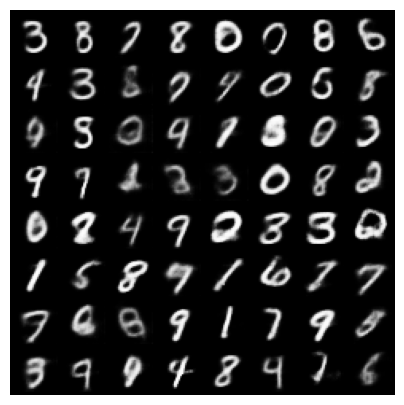

EPOCH: 6.000  val_log_var: -1.110  train_mean: 0.002  val_mean: 0.003  train_recon: 1163.122  train_log_var: -1.095  train_kld: 700.220  train_loss: 1863.342  val_kld: 698.131  val_loss: 1572.012  val_recon: 873.881  (129.18s - 86.12s remaining)


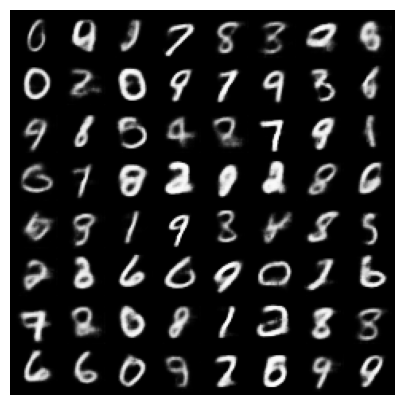

EPOCH: 7.000  val_log_var: -1.126  train_mean: 0.001  val_mean: -0.006  train_recon: 1135.438  train_log_var: -1.111  train_kld: 710.479  train_loss: 1845.917  val_kld: 709.543  val_loss: 1563.089  val_recon: 853.546  (150.80s - 64.63s remaining)


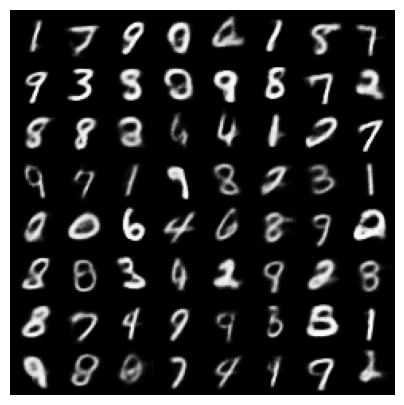

EPOCH: 8.000  val_log_var: -1.177  train_mean: 0.002  val_mean: 0.006  train_recon: 1118.114  train_log_var: -1.117  train_kld: 714.466  train_loss: 1832.580  val_kld: 758.861  val_loss: 1578.928  val_recon: 820.068  (172.48s - 43.12s remaining)


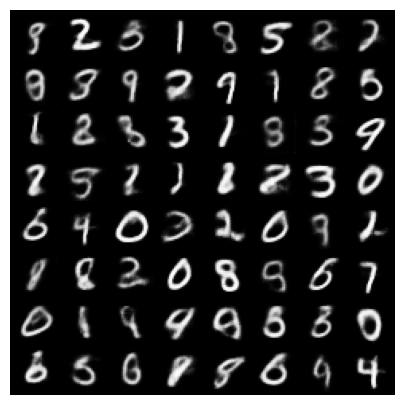

EPOCH: 9.000  val_log_var: -1.162  train_mean: 0.002  val_mean: 0.010  train_recon: 1102.253  train_log_var: -1.126  train_kld: 720.334  train_loss: 1822.588  val_kld: 737.655  val_loss: 1549.964  val_recon: 812.309  (194.31s - 21.59s remaining)


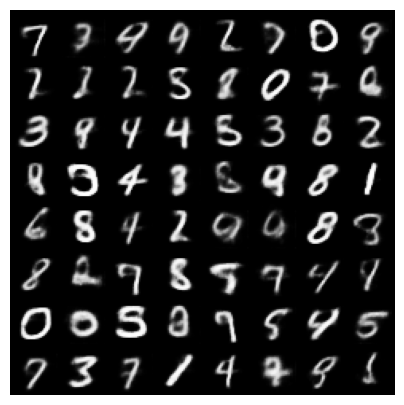

EPOCH: 10.000  val_log_var: -1.132  train_mean: 0.002  val_mean: 0.008  train_recon: 1089.721  train_log_var: -1.134  train_kld: 724.538  train_loss: 1814.259  val_kld: 722.729  val_loss: 1518.835  val_recon: 796.107  (215.87s - 0.00s remaining)


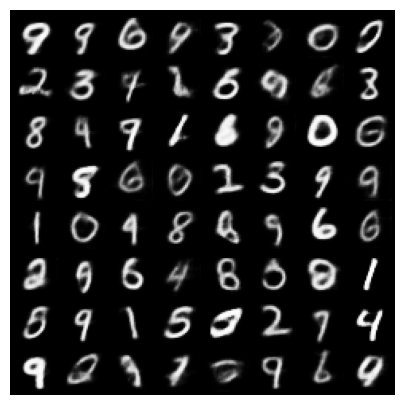

In [20]:
n_epochs = 10
log = Report(n_epochs)
vae = VAE().to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-3)


for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(data, vae, optimizer, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, train_loss=loss, train_kld=kld, train_recon=recon, train_log_var=log_var, train_mean=mean, end='\r')
        
    N = len(test_loader)
    for batch_idx, (data, _) in enumerate(test_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, val_loss=loss, val_kld=kld, val_recon=recon, val_log_var=log_var, val_mean=mean, end='\r')
        
    log.report_avgs(epoch+1)
    with torch.no_grad():
        z = torch.randn(64, 20).to(device)
        sample = vae.decode(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0)
        show(images)

100%|██████████| 111/111 [00:00<00:00, 898.48it/s]


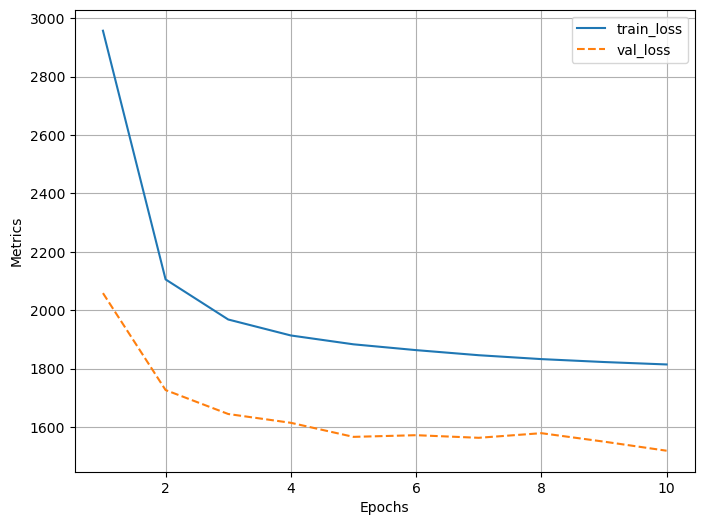

In [21]:
log.plot_epochs(['train_loss','val_loss'])